# Chapter 1

In [2]:
%matplotlib inline

In [3]:
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

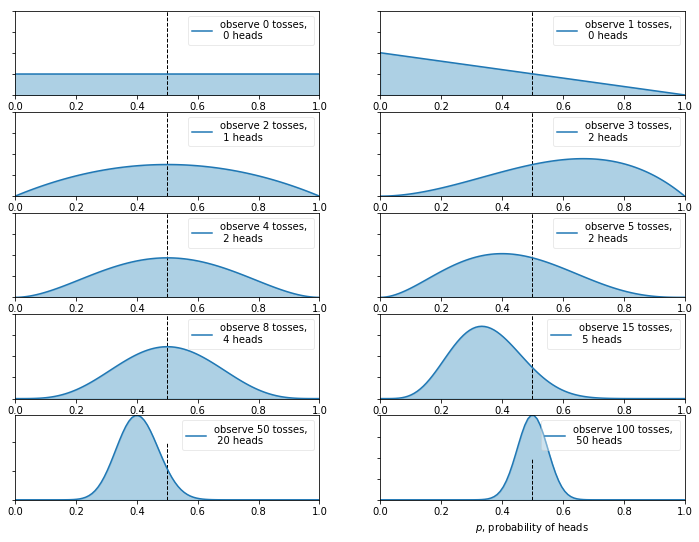

In [6]:
dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 100]
data = stats.bernoulli.rvs(0.5, size=n_trials[-1])
x = np.linspace(0, 1, 100)

fig = plt.figure(figsize=(12, 9))
for k, n in enumerate(n_trials):
    sx = plt.subplot(len(n_trials)/2, 2, k+1)
    plt.xlabel('$p$, probability of heads') \
        if k in [0, len(n_trials)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:n].sum()
    y = dist.pdf(x, 1+heads, 1+n-heads)
    plt.plot(x, y, label='observe %d tosses, \n %d heads' % (n, heads))
    plt.fill_between(x, 0, y, color='#348ABD', alpha=0.4)
    plt.vlines(0.5, 0, 4, color='k', linestyles='--', lw=1)
    
    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)

Text(0.5, 0, '$k$')

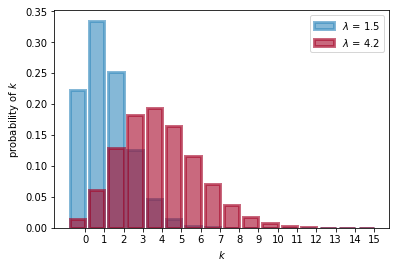

In [9]:
a = np.arange(16)
poi = stats.poisson

lambda_ = [1.5, 4.25]
colours = ['#348ABD', '#A60628']

plt.bar(a, poi.pmf(a, lambda_[0]), color=colours[0], label='$\lambda$ = %.1f' % lambda_[0], alpha=0.60,
        edgecolor=colours[0], lw='3')
plt.bar(a, poi.pmf(a, lambda_[1]), color=colours[1], label='$\lambda$ = %.1f' % lambda_[1], alpha=0.60,
        edgecolor=colours[1], lw='3')

plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel('probability of $k$')
plt.xlabel('$k$');

In [8]:
import pandas as pd

In [15]:
count_data = pd.read_csv('../Chapter1_Introduction/data/txtdata.csv', header=None)[0].values

(0, 74)

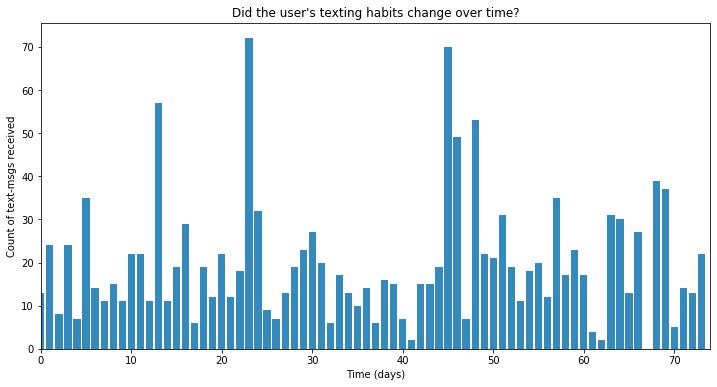

In [16]:
n_count_data = len(count_data)
fig = plt.figure(figsize=(12, 6))
plt.bar(np.arange(n_count_data), count_data, color='#348ABD')
plt.xlabel('Time (days)')
plt.ylabel('Count of text-msgs received')
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)

In [18]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/count_data.mean() # count_data is the variable that holds our txt counts
    lambda_1 = pm.Exponential('lambda_1', alpha)
    lambda_2 = pm.Exponential('lambda_2', alpha)
    
    tau = pm.DiscreteUniform('tau', lower=0, upper=n_count_data-1)

In [19]:
with model:
    idx = np.arange(n_count_data)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [20]:
with model:
    observation = pm.Poisson('obs', lambda_, observed=count_data)

In [21]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains: 100%|██████████| 60000/60000 [00:12<00:00, 4864.64draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [22]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

/home/yl238/projects/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/home/yl238/projects/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/venv/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


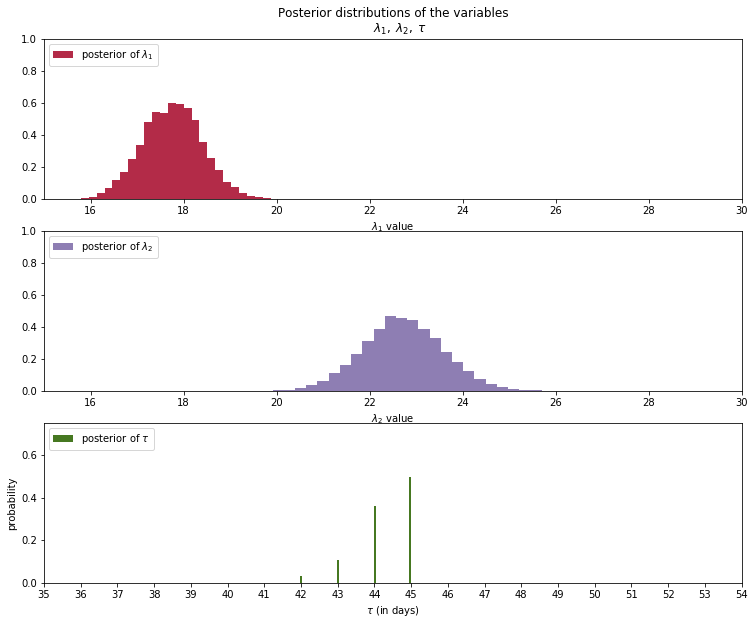

In [23]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

## Sample from the posterior

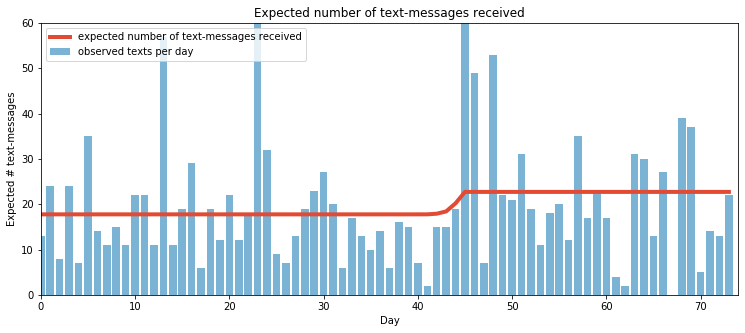

In [24]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N

plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");